In [58]:
#LIBRERIAS

import numpy as np 
import random
import warnings
import copy
import pandas as pd
import time 
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm






In [38]:
#CLASE INDIVIDUO

"""" Esta clase representa un individuo con unas características inicial definida
    por una combinación de valores numéricos aleatorios. El rango de posibles
    valores para cada variable puede estar acotado."""


class Individuo:
    
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):
        
        # Número de variables del individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Valor de las variables del individuo
        self.valor_variables = np.repeat(None, n_variables)
        # Fitness del individuo
        self.fitness = None
        # Valor de la función objetivo
        self.valor_funcion = None
        
    # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en arraynumpy
        
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf, np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
            
            
      # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )
            
            # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------

        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las 
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las 
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        # BUCLE PARA ASIGNAR UN VALOR A CADA UNA DE LAS VARIABLES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_variables):
        # Para cada variable, se genera un valor aleatorio dentro del rango
        # permitido para esa variable.
            self.valor_variables[i] = random.uniform(
                                        self.limites_inf[i],
                                        self.limites_sup[i]
                                      ) 
        # INFORMACIÓN DEL PROCESO (VERBOSE) : MUESTRA LA INFO DEL INDIVIDUO CREADO
        #----------------------------------------------------------------------
        if verbose:
            print("Nuevo individuo creado")
            print("----------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("")

            
    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto individuo.

        """

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Valor variables: " + str(self.valor_variables) \
                + "\n" \
                + "Valor función objetivo: " + str(self.valor_funcion) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)
    
    
    def calcular_fitness(self, funcion_objetivo, optimizacion, verbose = False):
        
         # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: 'maximizar' o 'minimizar'"
                )

        # EVALUACIÓN DE LA FUNCIÓN OBJETIVO CON LAS VARIABLES DEL INDIVIDUO Y
        # CÁLCULO DEL FITNESS
        # ----------------------------------------------------------------------
        self.valor_funcion = funcion_objetivo(*self.valor_variables)
        if optimizacion == "maximizar":
            self.fitness = self.valor_funcion
        elif optimizacion == "minimizar":
            self.fitness = -self.valor_funcion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")
        
  
    def mutar(self, prob_mut=0.01, distribucion="uniforme", media_distribucion=1,
              sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
              verbose=False):
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not distribucion in ["normal", "uniforme", "aleatoria"]:
            raise Exception(
                "El argumento distribucion debe ser: 'normal', 'uniforme' o " \
                + "'aleatoria'"
                )

        # SELECCIÓN PROBABILISTA DE POSICIONES (VARIABLES) QUE MUTAN
        #-----------------------------------------------------------------------
        posiciones_mutadas = np.random.uniform(
                                low=0,
                                high=1,
                                size=self.n_variables
                             )
        posiciones_mutadas = posiciones_mutadas < prob_mut

        # MODIFICACIÓN DE LOS VALORES DE LAS VARIABLES SELECCIONADAS
        #-----------------------------------------------------------------------
        # Si la distribución seleccionada es "uniforme" o "normal", se extrae un
        # valor aleatorio de la distribución elegida que se suma para modificar
        # la/las posiciones mutadas.

        if distribucion in ["normal", "uniforme"]:
            if distribucion == "normal":
                factor_mut = np.random.normal(
                                loc   = media_distribucion,
                                scale = sd_distribucion,
                                size  = np.sum(posiciones_mutadas)
                             )
            if distribucion == "uniforme":
                factor_mut = np.random.uniform(
                                low  = min_distribucion,
                                high = max_distribucion,
                                size = np.sum(posiciones_mutadas)
                             )
            self.valor_variables[posiciones_mutadas] = \
                self.valor_variables[posiciones_mutadas] + factor_mut

            # Se comprueba si algún valor mutado supera los límites impuestos.
            # En tal caso se sobrescribe con el valor del límite correspondiente.
            for i in np.flatnonzero(posiciones_mutadas):
                if self.valor_variables[i] < self.limites_inf[i]:
                    self.valor_variables[i] = self.limites_inf[i]
                if self.valor_variables[i] > self.limites_sup[i]:
                    self.valor_variables[i] = self.limites_sup[i]

        # Si la distribución seleccionada es "aleatoria", se sobreescribe el
        # valor de la variable con un nuevo valor aleatorio dentro de los 
        # límites establecidos.
        if distribucion == "aleatoria":
            for i in np.flatnonzero(posiciones_mutadas):
                self.valor_variables[i] = random.uniform(
                                            self.limites_inf[i],
                                            self.limites_sup[i]
                                          )
        # REINICIO DEL VALOR Y DEL FITNESS
        #-----------------------------------------------------------------------
        # Dado que el individuo ha mutado, el valor de su fitness y de la
        # función objetivo ya no son validos.
        self.fitness = None
        self.valor_funcion = None

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Total mutaciones: " + str(np.sum(posiciones_mutadas)))
            print("Valor variables: " + str(self.valor_variables))
            print("")
        
        


        
        
        
        
        

In [32]:
class Poblacion:
    
    def __init__(self, n_individuos, n_variables, limites_inf=None,
                 limites_sup=None, verbose=False):
        
        
        # Número de individuos de la población
        self.n_individuos = n_individuos
        # Número de variables de cada individuo
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Lista de los individuos de la población
        self.individuos = []
        # Etiqueta para saber si la población ha sido optimizada
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor individuo de la población
        self.mejor_individuo = None
        # Fitness del mejor individuo de la población (el de mayor fitness)
        self.mejor_fitness = None
        # Valor de la función objetivo del mejor individuo de la población
        self.mejor_valor_funcion = None
        # Valor de las variables del mejor individuo de la población
        self.mejor_valor_variables = None
        # Información de todas los individuos de la población en cada generación
        self.historico_individuos = []
        # Valor de las variables del mejor individuo en cada generación
        self.historico_mejor_valor_variables = []
        # Fitness del mejor individuo en cada generación
        self.historico_mejor_fitness = []
        # Valor de la función objetivo del mejor individuo en cada generación
        self.historico_mejor_valor_funcion = []
        # Diferencia absoluta entre el mejor fitness de generaciones consecutivas
        self.diferencia_abs = []
        # data.frame con la información del mejor fitness y valor de variables
        # encontrado en cada generación, así como la diferencia respecto a la 
        # generación anterior.
        self.resultados_df = None
        # Fitness del mejor individuo de todas las generaciones
        self.fitness_optimo = None
        # Valor de las variables del mejor individuo de todas las generaciones
        self.valor_variables_optimo = None
        # Valor de función objetivo del mejor individuo de todas las generaciones
        self.valor_funcion_optimo = None


        #CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # SE CREAN LOS INDIVIDUOS DE LA POBLACIÓN Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_individuos):
            individuo_i = Individuo(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = verbose
                          )
            self.individuos.append(individuo_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

            
            
        def __repr__(self):
            
            texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                     + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Valor variables: " + str(self.mejor_valor_variables) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Valor óptimo de variables: " + str(self.valor_variables_optimo) \
                + "\n" \
                + "Valor óptimo función objetivo: " + str(self.valor_funcion_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)
                
                
        return(texto)
    
    
    
    def mostrar_individuos(self, n=None):
        if n is None:
                n = self.n_individuos
        elif n > self.n_individuos:
                n = self.n_individuos

        for i in np.arange(n):
                print(self.individuos[i])
        return(None)
        
    def evaluar_poblacion(self, funcion_objetivo, optimizacion, verbose=False):
        
        # SE EVALÚA CADA INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos):
            self.individuos[i].calcular_fitness(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
            )

        # MEJOR INDIVIDUO DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        # Se identifica el mejor individuo de toda el población, el de mayor
        # fitness.

        # Se selecciona inicialmente como mejor individuo el primero.
        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        # Se comparan todas los individuos de la población.
        for i in np.arange(self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        # Se extrae la información del mejor individuo de la población.
        self.mejor_fitness = self.mejor_individuo.fitness
        self.mejor_valor_variables = self.mejor_individuo.valor_variables
        self.mejor_valor_funcion = self.mejor_individuo.valor_funcion
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Valor de la función objetivo: " \
                + str(self.mejor_valor_funcion))
            print("Mejor valor de variables encontrado : "
                + str(self.mejor_valor_variables))
            print("")
            
            
            
    def cruzar_individuos(self, parental_1, parental_2, verbose=False):
        
         # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if parental_1 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_1 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        if parental_2 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_2 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        
        # CREACIÓN DE LA DESCENDENCIA
        # ----------------------------------------------------------------------
        # Se extraen los parentales acorde a los índices indicados.
        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]
        
        # Se clona uno de los parentales para utilizarlo como plantilla del nuevo
        # individuo.
        descendencia = copy.deepcopy(parental_1)
        descendencia.valor_variables = np.repeat(None, descendencia.n_variables)
        descendencia.fitness = None

        # Se seleccionan aleatoriamente las posiciones que se heredan del
        # parental_1 y del parental 2.
        herencia_parent_1 = np.random.choice(
                                a       = [True, False],
                                size    = descendencia.n_variables,
                                p       = [0.5, 0.5],
                                replace = True
                            )
        herencia_parent_2 = np.logical_not(herencia_parent_1)

        # Se transfieren los valores al nuevo individuo.
        descendencia.valor_variables[herencia_parent_1] \
            = parental_1.valor_variables[herencia_parent_1]

        descendencia.valor_variables[herencia_parent_2] \
            = parental_2.valor_variables[herencia_parent_2]
        
        # Se crea un deepcopy para que el nuevo individuo sea independiente de 
        # los parentales. Esto evita problemas si posteriormente se muta.
        descendencia = copy.deepcopy(descendencia)
        
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("------------------------------------")
            print("Cruce realizado: descendencia creada")
            print("------------------------------------")
            print("Valor variables: " + str(descendencia.valor_variables))
            print("")
        return(descendencia)
    
    
    def seleccionar_individuo(self, n, return_indices=True,
                              metodo_seleccion="tournament", verbose=False):
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if metodo_seleccion not in ["ruleta", "rank", "tournament"]:
            raise Exception(
                "El método de selección debe de ser ruleta, rank o tournament"
                )
        
        # SELECCIÓN DE INDIVIDUOS
        # ----------------------------------------------------------------------
        # Se crea un array con el fitness de cada individuo de la población.
        array_fitness = np.repeat(None, self.n_individuos)
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)
        
        # Se calcula la probabilidad de selección de cada individuo en función
        # de su fitness.
        if metodo_seleccion == "ruleta":
            probabilidad_seleccion = array_fitness / np.sum(array_fitness)
            ind_seleccionado = np.random.choice(
                                    a       = np.arange(self.n_individuos),
                                    size    = n,
                                    p       = list(probabilidad_seleccion),
                                    replace = True
                               )
        elif metodo_seleccion == "rank":
            # La probabilidad con este método es inversamente proporcional a la
            # posición en la que quedan ordenados los individuos de menor a mayor
            # fitness.
            order = np.flip(np.argsort(a=array_fitness) + 1)
            ranks = np.argsort(order) + 1
            probabilidad_seleccion = 1 / ranks
            probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
            ind_seleccionado = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = n,
                                p       = list(probabilidad_seleccion),
                                replace = True
                            )
        elif metodo_seleccion == "tournament":
            ind_seleccionado = np.repeat(None,n)
            for i in np.arange(n):
                # Se seleccionan aleatoriamente dos parejas de individuos.
                candidatos_a = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                candidatos_b = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                # De cada pareja se selecciona el de mayor fitness.
                if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                    ganador_a = candidatos_a[0]
                else:
                    ganador_a = candidatos_a[1]

                if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                    ganador_b = candidatos_b[0]
                else:
                    ganador_b = candidatos_b[1]

                # Se comparan los dos ganadores de cada pareja.
                if array_fitness[ganador_a] > array_fitness[ganador_b]:
                    ind_final = ganador_a
                else:
                    ind_final = ganador_b
                
                ind_seleccionado[i] = ind_final

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------")
            print("Individuo seleccionado")
            print("---------------")
            print("Método selección: " + metodo_seleccion)
            print("")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )
            
            
    #NUEVA         
            
    def crear_nueva_generecion(self, metodo_seleccion="tournament",
                               elitismo=0.1, prob_mut=0.01,
                               distribucion="uniforme",
                               media_distribucion=1, sd_distribucion=1,
                               min_distribucion=-1, max_distribucion=1,
                               verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):
        
        
         # Lista donde almacenar los individuos de la nueva generación.
        nuevos_individuos = []

        # ELITISMO
        # ----------------------------------------------------------------------
        if elitismo > 0:
            # Número de individuos que pasan directamente a la siguiente
            # generación.
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))

            # Se identifican los n_elitismo individuos con mayor fitness (élite).
            array_fitness = np.repeat(None, self.n_individuos)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness))
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            # Se añaden los individuos élite a la lista de nuevos individuos.
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0
            
        # CREACIÓN DE NUEVOS INDIVIDUOS POR CRUCES
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    metodo_seleccion = metodo_seleccion,
                                    verbose          = verbose_seleccion
                                 )
            # Cruzar parentales para obtener la descendencia
            descendencia = self.cruzar_individuos(
                            parental_1 = indice_parentales[0],
                            parental_2 = indice_parentales[1],
                            verbose    = verbose_cruce
                           )
            # Mutar la descendencia
            descendencia.mutar(
                prob_mut         = prob_mut,
                distribucion     = distribucion,
                min_distribucion = min_distribucion,
                max_distribucion = max_distribucion,
                verbose          = verbose_mutacion
            )
            # Se añade la descendencia a la lista de nuevos individuos. Para
            # que no de error la unión, se introduce el individuo descendencia
            # dentro de una lista.
            nuevos_individuos = nuevos_individuos + [descendencia]

        # ACTUALIZACIÓN INFORMACIÓN DE LA POBLACIÓN
        # ----------------------------------------------------------------------
        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_variables = None
        self.mejor_valor_funcion = None
        
        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------------")
            print("Nueva generación creada")
            print("-----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")
    
    
    #FUNCION FINAL 
    
    def optimizar(self, funcion_objetivo, optimizacion, n_generaciones = 50,
                  metodo_seleccion="tournament", elitismo=0.1, prob_mut=0.01,
                  distribucion="uniforme", media_distribucion=1,
                  sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None,verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):
        
        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # ITERACIONES (GENERACIONES)
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")
            
            # EVALUAR INDIVIDUOS DE LA POBLACIÓN
            # ------------------------------------------------------------------
            self.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose_evaluacion
                )

            # SE ALMACENA LA INFORMACIÓN DE LA GENERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_valor_variables.append(
                                    copy.deepcopy(self.mejor_valor_variables)
                                )
            self.historico_mejor_valor_funcion.append(
                                    copy.deepcopy(self.mejor_valor_funcion)
                                )

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA GENERACIÓN ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # generación.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores individuos no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break
            # CREAR UNA NUEVA GENERACIÓN
            # ------------------------------------------------------------------         
            self.crear_nueva_generecion(
                metodo_seleccion   = metodo_seleccion,
                elitismo           = elitismo,
                prob_mut           = prob_mut,
                distribucion       = distribucion,
                verbose            = verbose_nueva_generacion,
                verbose_seleccion  = verbose_seleccion,
                verbose_cruce      = verbose_cruce,
                verbose_mutacion   = verbose_mutacion
                )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_funcion_optimo = self\
                                    .historico_mejor_valor_funcion[indice_valor_optimo]
        self.valor_variables_optimo = self\
                                      .historico_mejor_valor_variables[indice_valor_optimo]
        
        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_funcion"  : self.historico_mejor_fitness,
            "mejor_valor_variables": self.historico_mejor_valor_variables,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Valor óptimo de las variables: " + str(self.valor_variables_optimo))
        print("Valor función objetivo: " + str(self.valor_funcion_optimo))
        print("")
    
    

In [41]:
#CREAR , EVALUAR Y MUTAR INDIVIDUO


individuo = Individuo(
            n_variables = 3,
            limites_inf = [-1 , 2 , 0],
            limites_sup = [4 , 10 , 20],
            verbose = False
    
) 

def funcion_objetivo(x_0 , x_1 , x_2):
    f = x_0**2 + x_1**2 + x_2**2
    return(f)

individuo.calcular_fitness(
        funcion_objetivo = funcion_objetivo,
        optimizacion  = "maximizar",
        verbose = False

)


individuo.mutar(
    prob_mut         = 0.5,
    distribucion     = "uniforme",
    min_distribucion = -1,
    max_distribucion = 1,
    verbose          = False
)






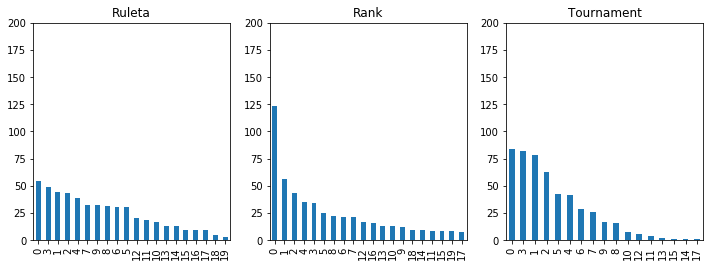

In [59]:
# COMPARACION ENTRE LOS METODOS DE RULETA , RANK Y TOURNAMENT


fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

array_fitness = np.array([20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7,
                          6, 5, 4, 3, 2, 1])

probabilidad_seleccion = array_fitness / np.sum(array_fitness)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Ruleta",
                                                  ax = axs[0])

order = np.flip(np.argsort(a=array_fitness) + 1)
ranks = np.argsort(order) + 1
probabilidad_seleccion = 1 / ranks
probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
ind_seleccionado = np.random.choice(
                    a    = np.arange(len(array_fitness)),
                    size = 500,
                    p    = list(probabilidad_seleccion),
                    replace = True
                   )
pd.value_counts(pd.Series(ind_seleccionado)).plot(kind="bar",
                                                  ylim=(0,200),
                                                  title = "Rank",
                                                  ax = axs[1])
indices_seleccionados = np.repeat(None,500)
for i in np.arange(500):
    # Se seleccionan aleatoriamente dos parejas de individuos.
    candidatos_a = np.random.choice(
                    a       = np.arange(len(array_fitness)),
                    size    = 2,
                    replace = False
                    )
    candidatos_b = np.random.choice(
                    a       = len(array_fitness),
                    size    = 2,
                    replace = False
                    )
    # De cada pareja se selecciona el de mayor fitness.
    if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
        ganador_a = candidatos_a[0]
    else:
        ganador_a = candidatos_a[1]

    if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
        ganador_b = candidatos_b[0]
    else:
        ganador_b = candidatos_b[1]

    # Se comparan los dos ganadores de cada pareja.
    if array_fitness[ganador_a] > array_fitness[ganador_b]:
        ind_seleccionado = ganador_a
    else:
        ind_seleccionado = ganador_b

    indices_seleccionados[i] = ind_seleccionado
    
pd.value_counts(pd.Series(indices_seleccionados)).plot(kind="bar", 
                                                       ylim=(0,200),
                                                       title = "Tournament",
                                                       ax=axs[2])


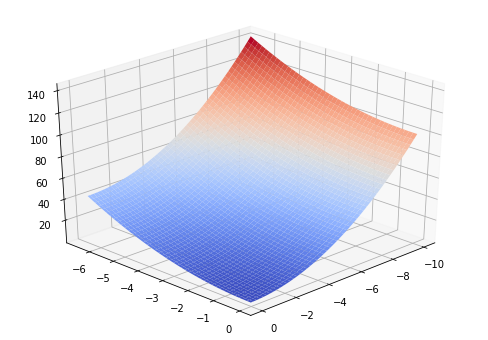

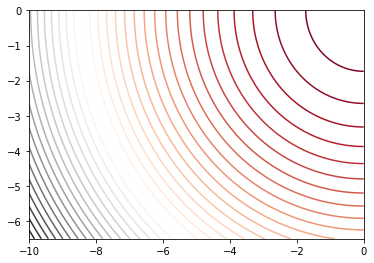

In [60]:
#GRAFICO 3D DE LA FUNCION OBJETIVO


fig = plt.figure(figsize=(8.5, 6))
ax = fig.add_subplot(111, projection='3d')


def funcion_objetivo(x_0, x_1):
  
    # SE ESCRIBE LA FUNCION A DETERMINAR 

    f = x_0**2 + x_1**2 + 1
    
    return(f)


# Grid de datos
x = np.arange(-10, 0, 0.05)
y = np.arange(-6.5, 0, 0.05)
x, y = np.meshgrid(x, y)
z = np.array(funcion_objetivo(np.ravel(x), np.ravel(y)))
z = z.reshape(x.shape)

grafico = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax.view_init(30, 45)


fig = plt.figure(figsize=(6, 4.2))
x_0 = np.linspace(start = -10, stop = 0, num = 100)
x_1 = np.linspace(start = -6.5, stop = 0, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
z = funcion_objetivo(x_0, x_1)
plt.contour(x_0, x_1, z, 35, cmap='RdGy')




